In [469]:
%matplotlib inline

In [470]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [471]:
import re
import sklearn as sk
import seaborn as sns

In [472]:
import warnings
warnings.filterwarnings('ignore')

In [473]:
from sklearn import preprocessing as pr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mr

In [474]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier

In [475]:
from sklearn.model_selection import train_test_split

## Просмотр, преобразование и чистка данных

In [413]:
df = pd.read_csv('scoring.csv', sep = ";", decimal = ".")
df.head()

,account,duration,credit_history,amount,savings,employment,guarantors,residence,age,credits_number,...,maintenance_people,telephone,foreign,real_estate,life_insurance,car,housing_rent,sex,purpose,target
0,1.0,"0,18",2.0,"0,1311",2.0,2.0,1.0,4.0,"0,34",1.0,...,1,0,1,0,0,1,0,1,business,1
1,-1.0,"0,18",0.0,"0,1552",1.0,3.0,1.0,1.0,"0,31",1.0,...,1,1,1,0,1,0,0,1,business,1
2,-1.0,"0,12",2.0,"0,0451",1.0,3.0,1.0,4.0,"0,21",1.0,...,1,0,1,0,1,0,1,1,retraining,0
3,-1.0,"0,3",0.0,"0,4036",0.0,1.0,1.0,3.0,"0,25",3.0,...,1,0,1,0,0,1,0,1,business,1
4,0.0,"0,36",2.0,"0,09095",1.0,2.0,1.0,4.0,"0,37",1.0,...,1,1,1,0,0,0,0,1,education,0


In [414]:
df.shape

(600, 21)

Имеем выборку с 600 элементами и 21 признаком. Целевым признаком является "target" - флаг, принимающий значение 0, если клиенту не следует выдавать кредит и 1 - если следует, по остальным 20 признакам необходимо спрогнозировать кредитоспособность потенциального заемщика.

In [415]:
df.dtypes

account               float64
duration               object
credit_history        float64
amount                 object
savings               float64
employment            float64
guarantors            float64
residence             float64
age                    object
credits_number        float64
job                   float64
maintenance_people      int64
telephone               int64
foreign                 int64
real_estate             int64
life_insurance          int64
car                     int64
housing_rent            int64
sex                     int64
purpose                object
target                  int64
dtype: object

Видим, что элементы выборки в столбцах "duration", "amount" и "age" - десятичные числа, разделенные запятыми и потому имеют тип object. Изменим их формат на числа с плавающей точкой.

In [416]:
df['duration'] = df['duration'].str.replace(',','.')
df['amount'] = df['amount'].str.replace(',','.')
df['age'] = df['age'].str.replace(',','.')
df.head(10)

,account,duration,credit_history,amount,savings,employment,guarantors,residence,age,credits_number,...,maintenance_people,telephone,foreign,real_estate,life_insurance,car,housing_rent,sex,purpose,target
0,1.0,0.18,2.0,0.1311,2.0,2.0,1.0,4.0,0.34,1.0,...,1,0,1,0,0,1,0,1,business,1
1,-1.0,0.18,0.0,0.1552,1.0,3.0,1.0,1.0,0.31,1.0,...,1,1,1,0,1,0,0,1,business,1
2,-1.0,0.12,2.0,0.0451,1.0,3.0,1.0,4.0,0.21,1.0,...,1,0,1,0,1,0,1,1,retraining,0
3,-1.0,0.3,0.0,0.4036,0.0,1.0,1.0,3.0,0.25,3.0,...,1,0,1,0,0,1,0,1,business,1
4,0.0,0.36,2.0,0.09095,1.0,2.0,1.0,4.0,0.37,1.0,...,1,1,1,0,0,0,0,1,education,0
5,1.0,0.24,3.0,0.1032,1.0,0.0,1.0,2.0,0.34,1.0,...,1,1,1,0,1,0,0,0,furniture,0
6,1.0,0.09,4.0,0.07505,1.0,4.0,1.0,3.0,0.34,2.0,...,1,1,1,0,0,1,0,0,education,0
7,-1.0,0.12,2.0,0.045,0.0,2.0,1.0,2.0,0.23,1.0,...,1,0,1,0,0,1,0,1,car_new,0
8,1.0,0.36,3.0,0.4043,2.0,4.0,1.0,4.0,0.42,4.0,...,1,1,1,0,0,1,0,1,car_new,0
9,-1.0,0.42,3.0,0.2185,1.0,3.0,1.0,2.0,0.26,2.0,...,2,1,1,0,1,0,0,1,television,0


In [417]:
df['duration'] = df['duration'].astype(float)
df['amount'] = df['amount'].astype(float)
df['age'] = df['age'].astype(float)

Кроме того, в наборе данных имеется категориальная переменная "purpose" (цель взятия кредита), преобразуем ее в количественную:

In [418]:
df["purpose"].value_counts() # подсчет уникальных значений

car_new                157
television             143
furniture              118
business                61
car_used                57
education               31
repairs                 13
others                  10
domestic_appliances      8
retraining               2
Name: purpose, dtype: int64

In [419]:
purposes = {"purpose": {"car_new":1, "television":2, "furniture":3, "business":4,
            "car_used":5, "education":6, "repairs":7, "others":8, "domestic_appliances":9,
            "retraining":10}} # словарь для замены категориального значения на количественное

In [420]:
df.replace(purposes, inplace = True)

In [421]:
df["purpose"].head(10)

0     4
1     4
2    10
3     4
4     6
5     3
6     6
7     1
8     1
9     2
Name: purpose, dtype: int64

Теперь необходимо удалить строки, содержащие пропущенные данные, либо заполнить пропуски.

In [422]:
df.isnull().sum() # подсчет кол-ва пропущенных данных по столбцам

account               1
duration              1
credit_history        1
amount                3
savings               2
employment            2
guarantors            3
residence             1
age                   3
credits_number        2
job                   2
maintenance_people    0
telephone             0
foreign               0
real_estate           0
life_insurance        0
car                   0
housing_rent          0
sex                   0
purpose               0
target                0
dtype: int64

In [423]:
df = df.dropna() # удаление пропущенных значений
df.head(5)

,account,duration,credit_history,amount,savings,employment,guarantors,residence,age,credits_number,...,maintenance_people,telephone,foreign,real_estate,life_insurance,car,housing_rent,sex,purpose,target
0,1.0,0.18,2.0,0.13110,2.0,2.0,1.0,4.0,0.34,1.0,...,1,0,1,0,0,1,0,1,4,1
1,-1.0,0.18,0.0,0.15520,1.0,3.0,1.0,1.0,0.31,1.0,...,1,1,1,0,1,0,0,1,4,1
2,-1.0,0.12,2.0,0.04510,1.0,3.0,1.0,4.0,0.21,1.0,...,1,0,1,0,1,0,1,1,10,0
3,-1.0,0.30,0.0,0.40360,0.0,1.0,1.0,3.0,0.25,3.0,...,1,0,1,0,0,1,0,1,4,1
4,0.0,0.36,2.0,0.09095,1.0,2.0,1.0,4.0,0.37,1.0,...,1,1,1,0,0,0,0,1,6,0


In [424]:
np.where(np.isnan(df))

(array([], dtype=int64), array([], dtype=int64))

In [425]:
df.dtypes # проверка типов данных после преобразований

account               float64
duration              float64
credit_history        float64
amount                float64
savings               float64
employment            float64
guarantors            float64
residence             float64
age                   float64
credits_number        float64
job                   float64
maintenance_people      int64
telephone               int64
foreign                 int64
real_estate             int64
life_insurance          int64
car                     int64
housing_rent            int64
sex                     int64
purpose                 int64
target                  int64
dtype: object

## Первичный анализ данных

Посмотрим, насколько равномерно распределены данные по значению целевого признака:

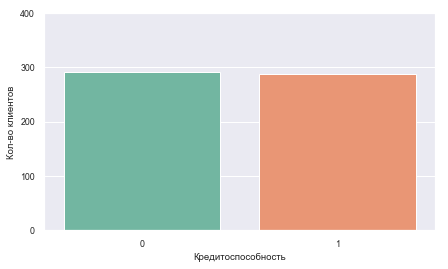

In [426]:
ax = sns.countplot(x = df.target, palette="Set2")
sns.set(font_scale = 2)
ax.set_ylim(top = 400)
ax.set_xlabel('Кредитоспособность')
ax.set_ylabel('Кол-во клиентов')
fig = plt.gcf()
fig.set_size_inches(7,4)
plt.show()

Построим корреляционную матрицу для всех признаков, включая целевой:

In [427]:
df.corr(method='pearson')

,account,duration,credit_history,amount,savings,employment,guarantors,residence,age,credits_number,...,maintenance_people,telephone,foreign,real_estate,life_insurance,car,housing_rent,sex,purpose,target
account,1.000000,-0.034214,0.044208,0.009647,0.117255,-0.062857,0.033447,-0.131421,-0.006464,-0.020664,...,-0.051089,0.056325,0.025967,0.050372,-0.064790,-0.008893,-0.064072,0.014585,-0.018257,0.098449
duration,-0.034214,1.000000,-0.077569,0.589127,-0.056855,0.064673,-0.047008,0.075940,-0.015055,0.001249,...,0.007910,0.163970,0.167424,-0.279836,-0.029588,0.089502,-0.025396,0.086004,0.131958,-0.233925
credit_history,0.044208,-0.077569,1.000000,-0.046391,-0.011634,0.121169,-0.013611,0.039085,0.124737,0.349612,...,-0.007467,0.077955,-0.074836,0.083035,-0.036475,-0.010692,-0.117521,0.058276,-0.053305,0.226000
amount,0.009647,0.589127,-0.046391,1.000000,-0.122566,0.009279,-0.055475,0.060807,0.072723,0.052141,...,-0.020496,0.309975,0.080746,-0.274441,0.003765,0.039656,-0.019754,0.089211,0.167101,-0.140665
savings,0.117255,-0.056855,-0.011634,-0.122566,1.000000,0.012868,0.057112,-0.001260,-0.039609,-0.003503,...,-0.024257,-0.030690,0.030083,0.024133,-0.012229,-0.005930,0.011366,-0.011422,-0.000505,0.080130
employment,-0.062857,0.064673,0.121169,0.009279,0.012868,1.000000,-0.031408,0.244969,0.266683,0.094212,...,0.116950,0.070822,0.038857,-0.049217,-0.082556,0.005991,-0.121326,0.232892,0.026577,0.139069
guarantors,0.033447,-0.047008,-0.013611,-0.055475,0.057112,-0.031408,1.000000,0.029481,0.042366,-0.013754,...,0.027243,0.061031,0.066193,-0.113177,-0.013127,0.103130,-0.080103,-0.003573,0.048410,-0.013930
residence,-0.131421,0.075940,0.039085,0.060807,-0.001260,0.244969,0.029481,1.000000,0.254491,0.113956,...,0.053009,0.108375,0.013965,-0.148511,-0.033792,-0.036470,0.190852,-0.028064,0.122377,-0.032509
age,-0.006464,-0.015055,0.124737,0.072723,-0.039609,0.266683,0.042366,0.254491,1.000000,0.153727,...,0.131436,0.193625,-0.010634,0.006199,-0.032380,-0.171787,-0.222416,0.215671,0.069600,0.105768
credits_number,-0.020664,0.001249,0.349612,0.052141,-0.003503,0.094212,-0.013754,0.113956,0.153727,1.000000,...,0.098890,0.121161,-0.043607,0.002277,-0.048972,0.030866,-0.027774,0.085740,-0.015641,0.010553


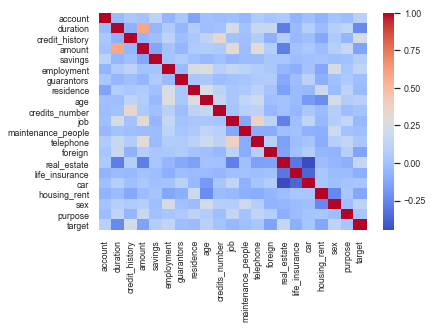

In [428]:
sns.set(font_scale = 0.8)
corrMatrix = sns.heatmap(df.corr(), annot = False, cmap = "coolwarm")

Убеждаемся в том, что признаки практически не коррелируют друг с другом (почти все парные коэффициенты корреляции $<0,25$).
   Рассмотрим статистическую информацию по каждому признаку:

In [429]:
for i in df.columns:
    print(df[i].describe())

count    580.000000
mean       0.075862
std        0.916800
min       -1.000000
25%       -1.000000
50%        0.000000
75%        1.000000
max        2.000000
Name: account, dtype: float64
count    580.000000
mean       0.217000
std        0.126531
min        0.040000
25%        0.120000
50%        0.180000
75%        0.262500
max        0.720000
Name: duration, dtype: float64
count    580.000000
mean       2.418966
std        1.089431
min        0.000000
25%        2.000000
50%        2.000000
75%        4.000000
max        4.000000
Name: credit_history, dtype: float64
count    580.000000
mean       0.170194
std        0.149179
min        0.012500
25%        0.067238
50%        0.116300
75%        0.214250
max        0.797250
Name: amount, dtype: float64
count    580.000000
mean       1.196552
std        0.921433
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        4.000000
Name: savings, dtype: float64
count    580.000000
mean       2.348276
std

Построим гистограммы, показывающие вероятность клиента оказаться надежным для банка, при различных значениях нецелевых признаков. Если высота столбцов будет близка к равномерной, то значение признака не оказывает значительного влияния на значение целевого признака.

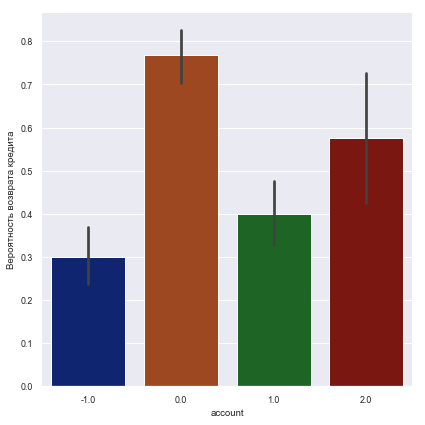

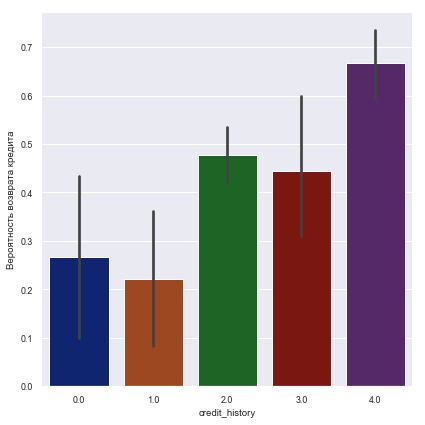

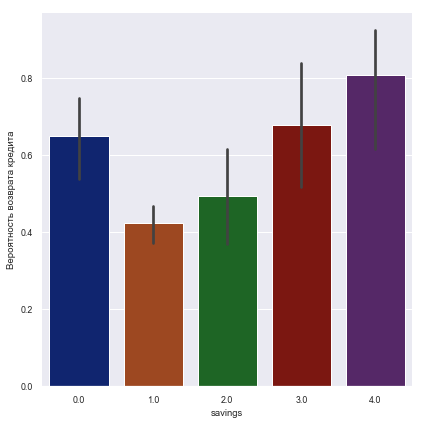

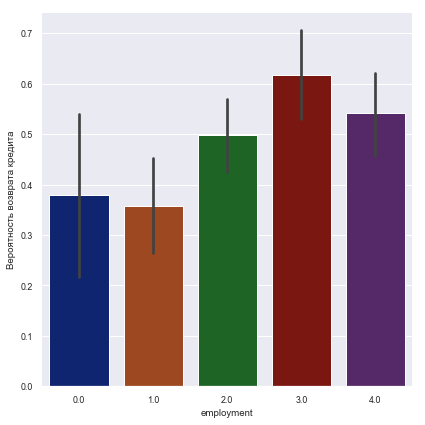

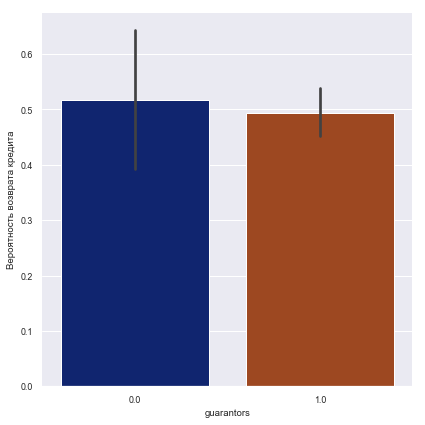

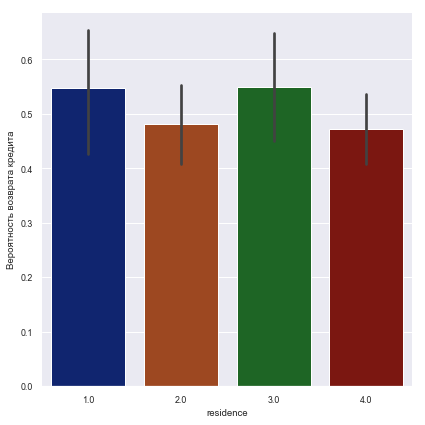

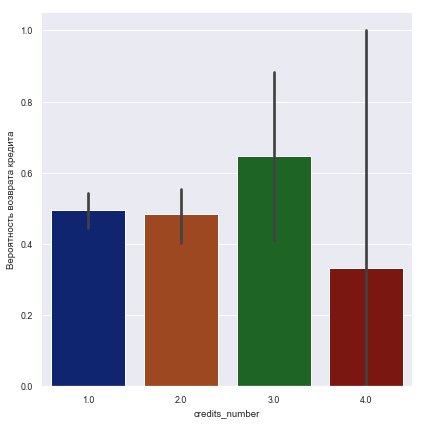

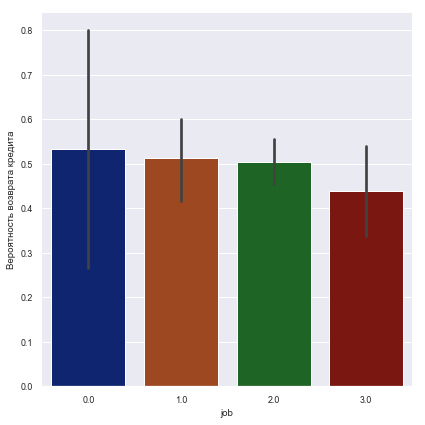

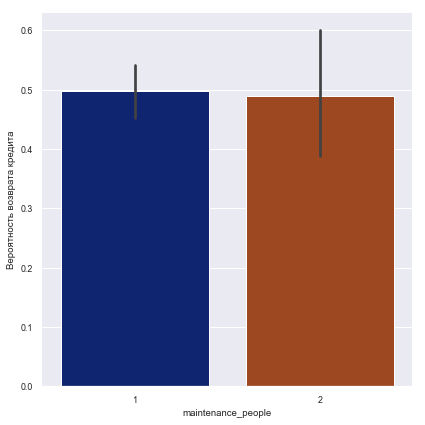

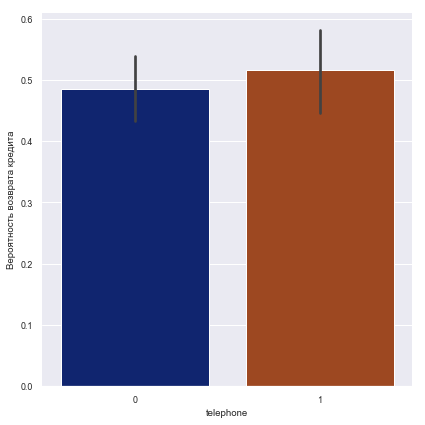

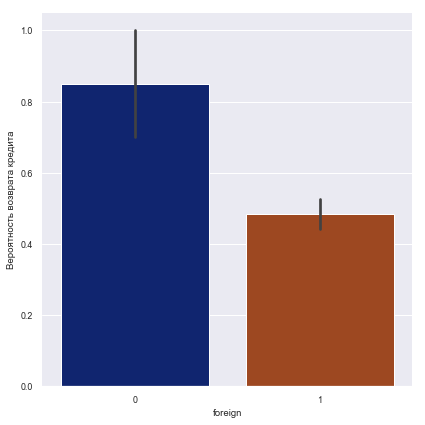

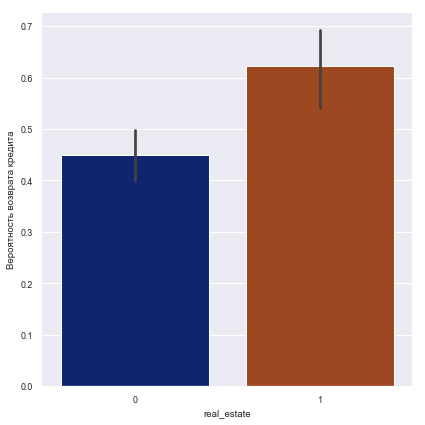

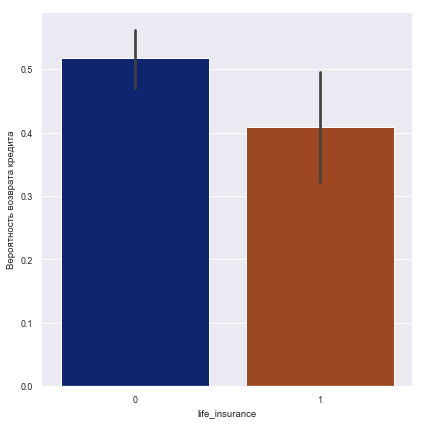

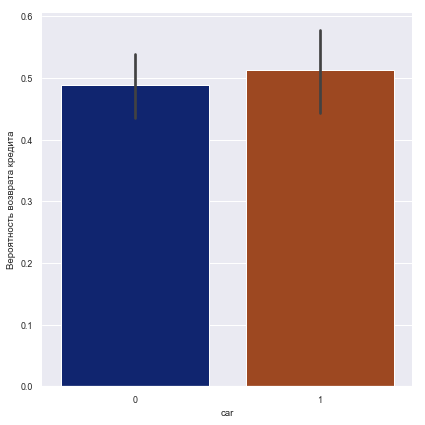

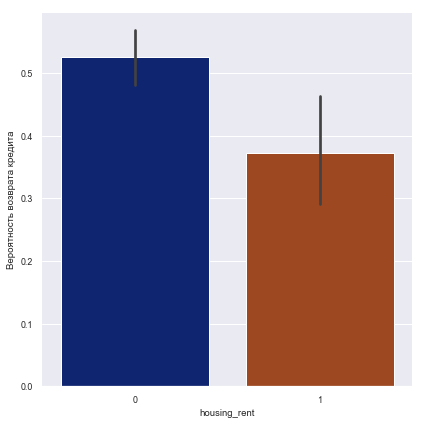

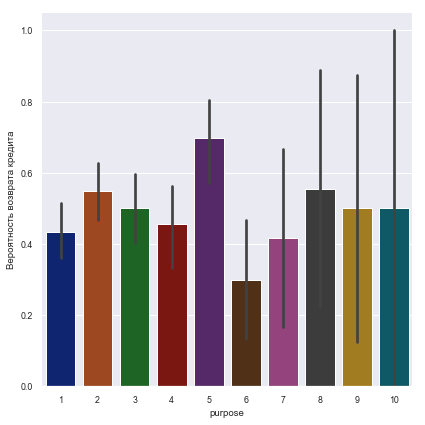

In [430]:
categorical = ["account", "credit_history", "savings", "employment", "guarantors", 
               "residence", "credits_number", "job", "maintenance_people",
               "telephone", "foreign", "real_estate", "life_insurance", "car",
               "housing_rent", "purpose"]
for category in categorical:
    g = sns.factorplot(x = category, y = "target", data = df, kind = "bar", 
                       size = 6, palette = "dark")
    g.despine(left = True)
    g = g.set_ylabels("Вероятность возврата кредита")

## Логистическая регрессия

Создаем датафрейм с регрессорами (все столбцы набора данных кроме последнего) и со значениями целевого признака:

In [383]:
x = df.iloc[:, 0:20].values
y = df.iloc[:, 20].values

Разделим данные на 2 составляющие: обучающую (75%) и тестовую (25%) выборки:

In [432]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)
#sc = pr.StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

In [433]:
# lda = LDA(n_components = 2)
np.where(np.isnan(X_train))

(array([], dtype=int64), array([], dtype=int64))

In [434]:
classifier = LogisticRegression()
classifier.fit(X_train, Y_train)
y_pred = classifier.predict(X_test)
y_pred, Y_test

(array([1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
        1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
        0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0], dtype=int64),
 array([1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
        1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
        1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
        0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
        1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0], dt

In [438]:
cm = mr.confusion_matrix(Y_test, y_pred)
print('Матрица ошибок для логистической регресии (по тестовой выборке):\n', cm)

Матрица ошибок для логистической регресии (по тестовой выборке):
 [[44 18]
 [30 53]]


In [478]:
print('Оценка для классификатора LogisticRegression:\n', classifier.score(X_test, Y_test))

Оценка для классификатора LogisticRegression:
 0.6827586206896552


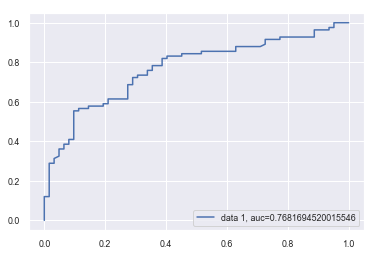

In [477]:
Y_pred_proba = classifier.predict_proba(X_test)[::,1]
fpr, tpr, _ = mr.roc_curve(Y_test,  Y_pred_proba)
auc = mr.roc_auc_score(Y_test, Y_pred_proba)
plt.plot(fpr, tpr, label = "data 1, auc = " + str(auc))
plt.legend(loc = 4)
plt.show()

## Random Forest

In [458]:
rf_score = []
rf_feat_importances = []
rf_conf_matrices = []

for i in range(2, 21):
    classifier = RandomForestClassifier(n_estimators = i, max_features = 'sqrt')
    classifier = classifier.fit(X_train, Y_train)
    score = classifier.score(X_test, Y_test)
    importance = classifier.feature_importances_
    y_pred = classifier.predict(X_test)
    rf_score.append(score)
    rf_feat_importances.append(importance)
    cm = mr.confusion_matrix(Y_test, y_pred)
    rf_conf_matrices.append(cm)
    
rf_best_score = max(rf_score)
rf_best_num_of_parameters = rf_score.index(rf_best_score) + 2
rf_best_cm = rf_conf_matrices[best_num_of_parameters - 2]
rf_optimal_importances = rf_feat_importances[best_num_of_parameters - 2]

In [234]:
#len(list(df.columns.values[:-1]))

20

In [235]:
#len(classifier.feature_importances_)

20

In [446]:
features = pd.DataFrame()
features['feature'] = list(df.columns.values[:-1])
features['importance'] = list(rf_optimal_importances)
features.sort_values(by = ['importance'], ascending = True, inplace = True)
features.set_index('feature', inplace = True)

In [459]:
print('Лучшая оценка для классификатора RandomForest:', rf_best_score)
print('Оптимальное количество параметров:', rf_best_num_of_parameters)
print('Матрица ошибок (для тестовой выборки):\n', rf_best_cm)

Лучшая оценка для классификатора RandomForest: 0.6896551724137931
Оптимальное количество параметров: 13
Матрица ошибок (для тестовой выборки):
 [[48 14]
 [43 40]]


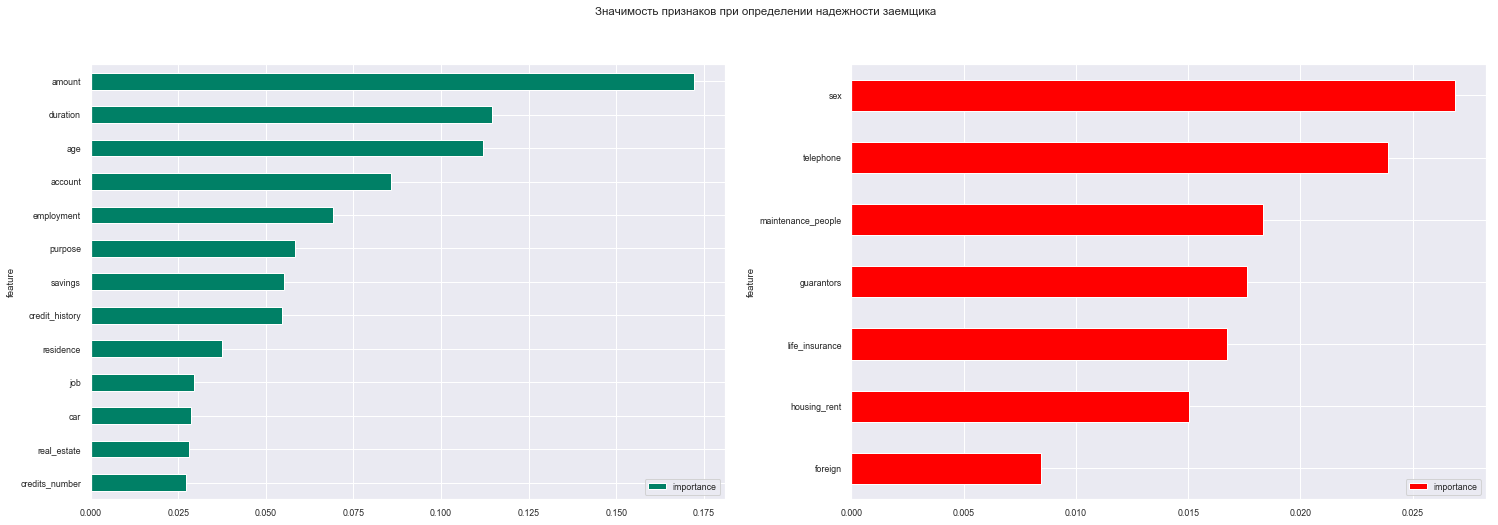

In [460]:
#colors = []
#for i in range(21):
    #if i < 13:
        #colors.append('g')
    #else:
        #colors.append('r')
fig, axes = plt.subplots(nrows = 1, ncols = 2)
fig.suptitle('Значимость признаков при определении надежности заемщика')
features[7:].plot(kind = 'barh', ax = axes[0], figsize = (10, 7), cmap = plt.get_cmap("summer"))
features[:7].plot(kind = 'barh', ax = axes[1], figsize = (25, 8), cmap = plt.get_cmap("autumn"))

## Градиентный бустинг

In [461]:
gb_score = []
gb_feat_importances = []
gb_conf_matrices = []

for i in range(2, 21):
    classifier = GradientBoostingClassifier(n_estimators = i)
    classifier = classifier.fit(X_train, Y_train)
    score = classifier.score(X_test, Y_test)
    importance = classifier.feature_importances_
    y_pred = classifier.predict(X_test)
    gb_score.append(score)
    gb_feat_importances.append(importance)
    cm = mr.confusion_matrix(Y_test, y_pred)
    gb_conf_matrices.append(cm)
    
gb_best_score = max(gb_score)
gb_best_num_of_parameters = gb_score.index(gb_best_score) + 2
gb_best_cm = gb_conf_matrices[best_num_of_parameters - 2]
gb_optimal_importances = gb_feat_importances[best_num_of_parameters - 2]

In [463]:
features = pd.DataFrame()
features['feature'] = list(df.columns.values[:-1])
features['importance'] = list(gb_optimal_importances)
features.sort_values(by = ['importance'], ascending = True, inplace = True)
features.set_index('feature', inplace = True)

In [464]:
print('Лучшая оценка для классификатора GradientBoosting:', gb_best_score)
print('Оптимальное количество параметров:', gb_best_num_of_parameters)
print('Матрица ошибок (для тестовой выборки):\n', gb_best_cm)

Лучшая оценка для классификатора GradientBoosting: 0.7310344827586207
Оптимальное количество параметров: 8
Матрица ошибок (для тестовой выборки):
 [[57  5]
 [34 49]]


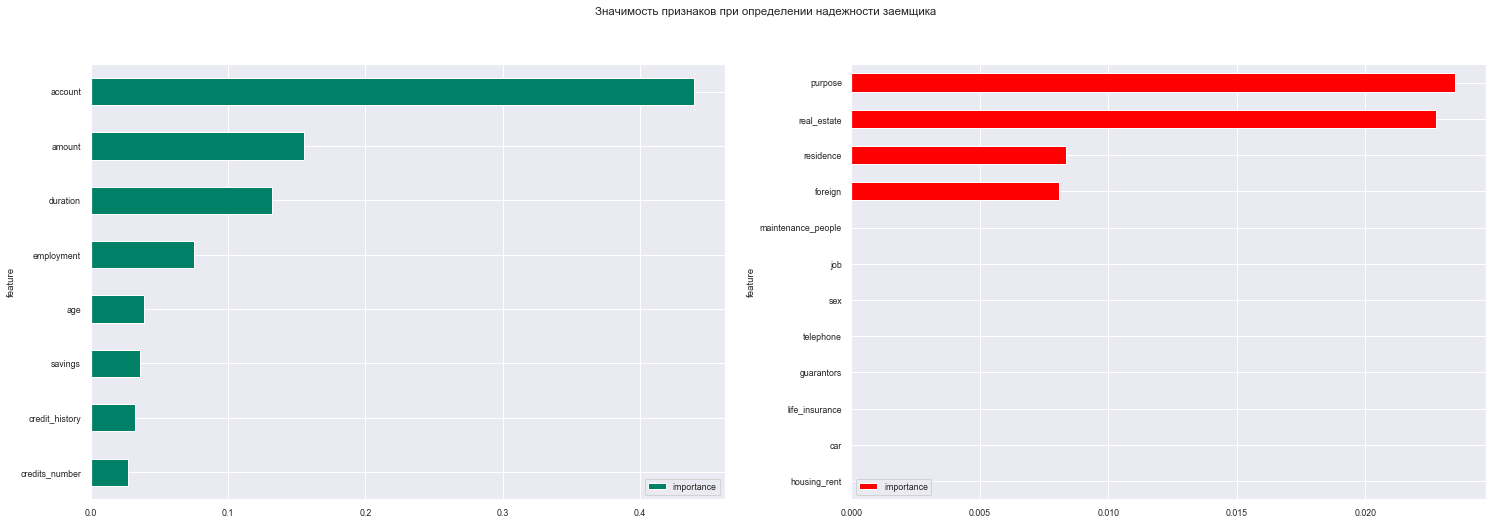

In [465]:
fig, axes = plt.subplots(nrows = 1, ncols = 2)
fig.suptitle('Значимость признаков при определении надежности заемщика')
features[12:].plot(kind = 'barh', ax = axes[0], figsize = (10, 7), cmap = plt.get_cmap("summer"))
features[:12].plot(kind = 'barh', ax = axes[1], figsize = (25, 8), cmap = plt.get_cmap("autumn"))